In [1]:
from network import *
from inference import *
import numpy as np
from tools import *
from os import listdir
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
seeds = [697752728, 4190089612, 1176914559, 3077924848, 315917623, 2544020234, 1077758578, 4071300106, 534591752, 3553386411]
Ts = [5,10,30,50,100]
K_exps = [3,6,9]

N = 100
avg_degree_A0 = 100
K_aff = 3
dirichlet = 1
prob_ratio = 0.1
symmetric = True

In [13]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook")
sns.color_palette("colorblind")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 45
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
from matplotlib import rc
rc("text", usetex=True)

In [14]:
in_folder = "../data/input/synth/"
out_folder = "../data/output/synth/"

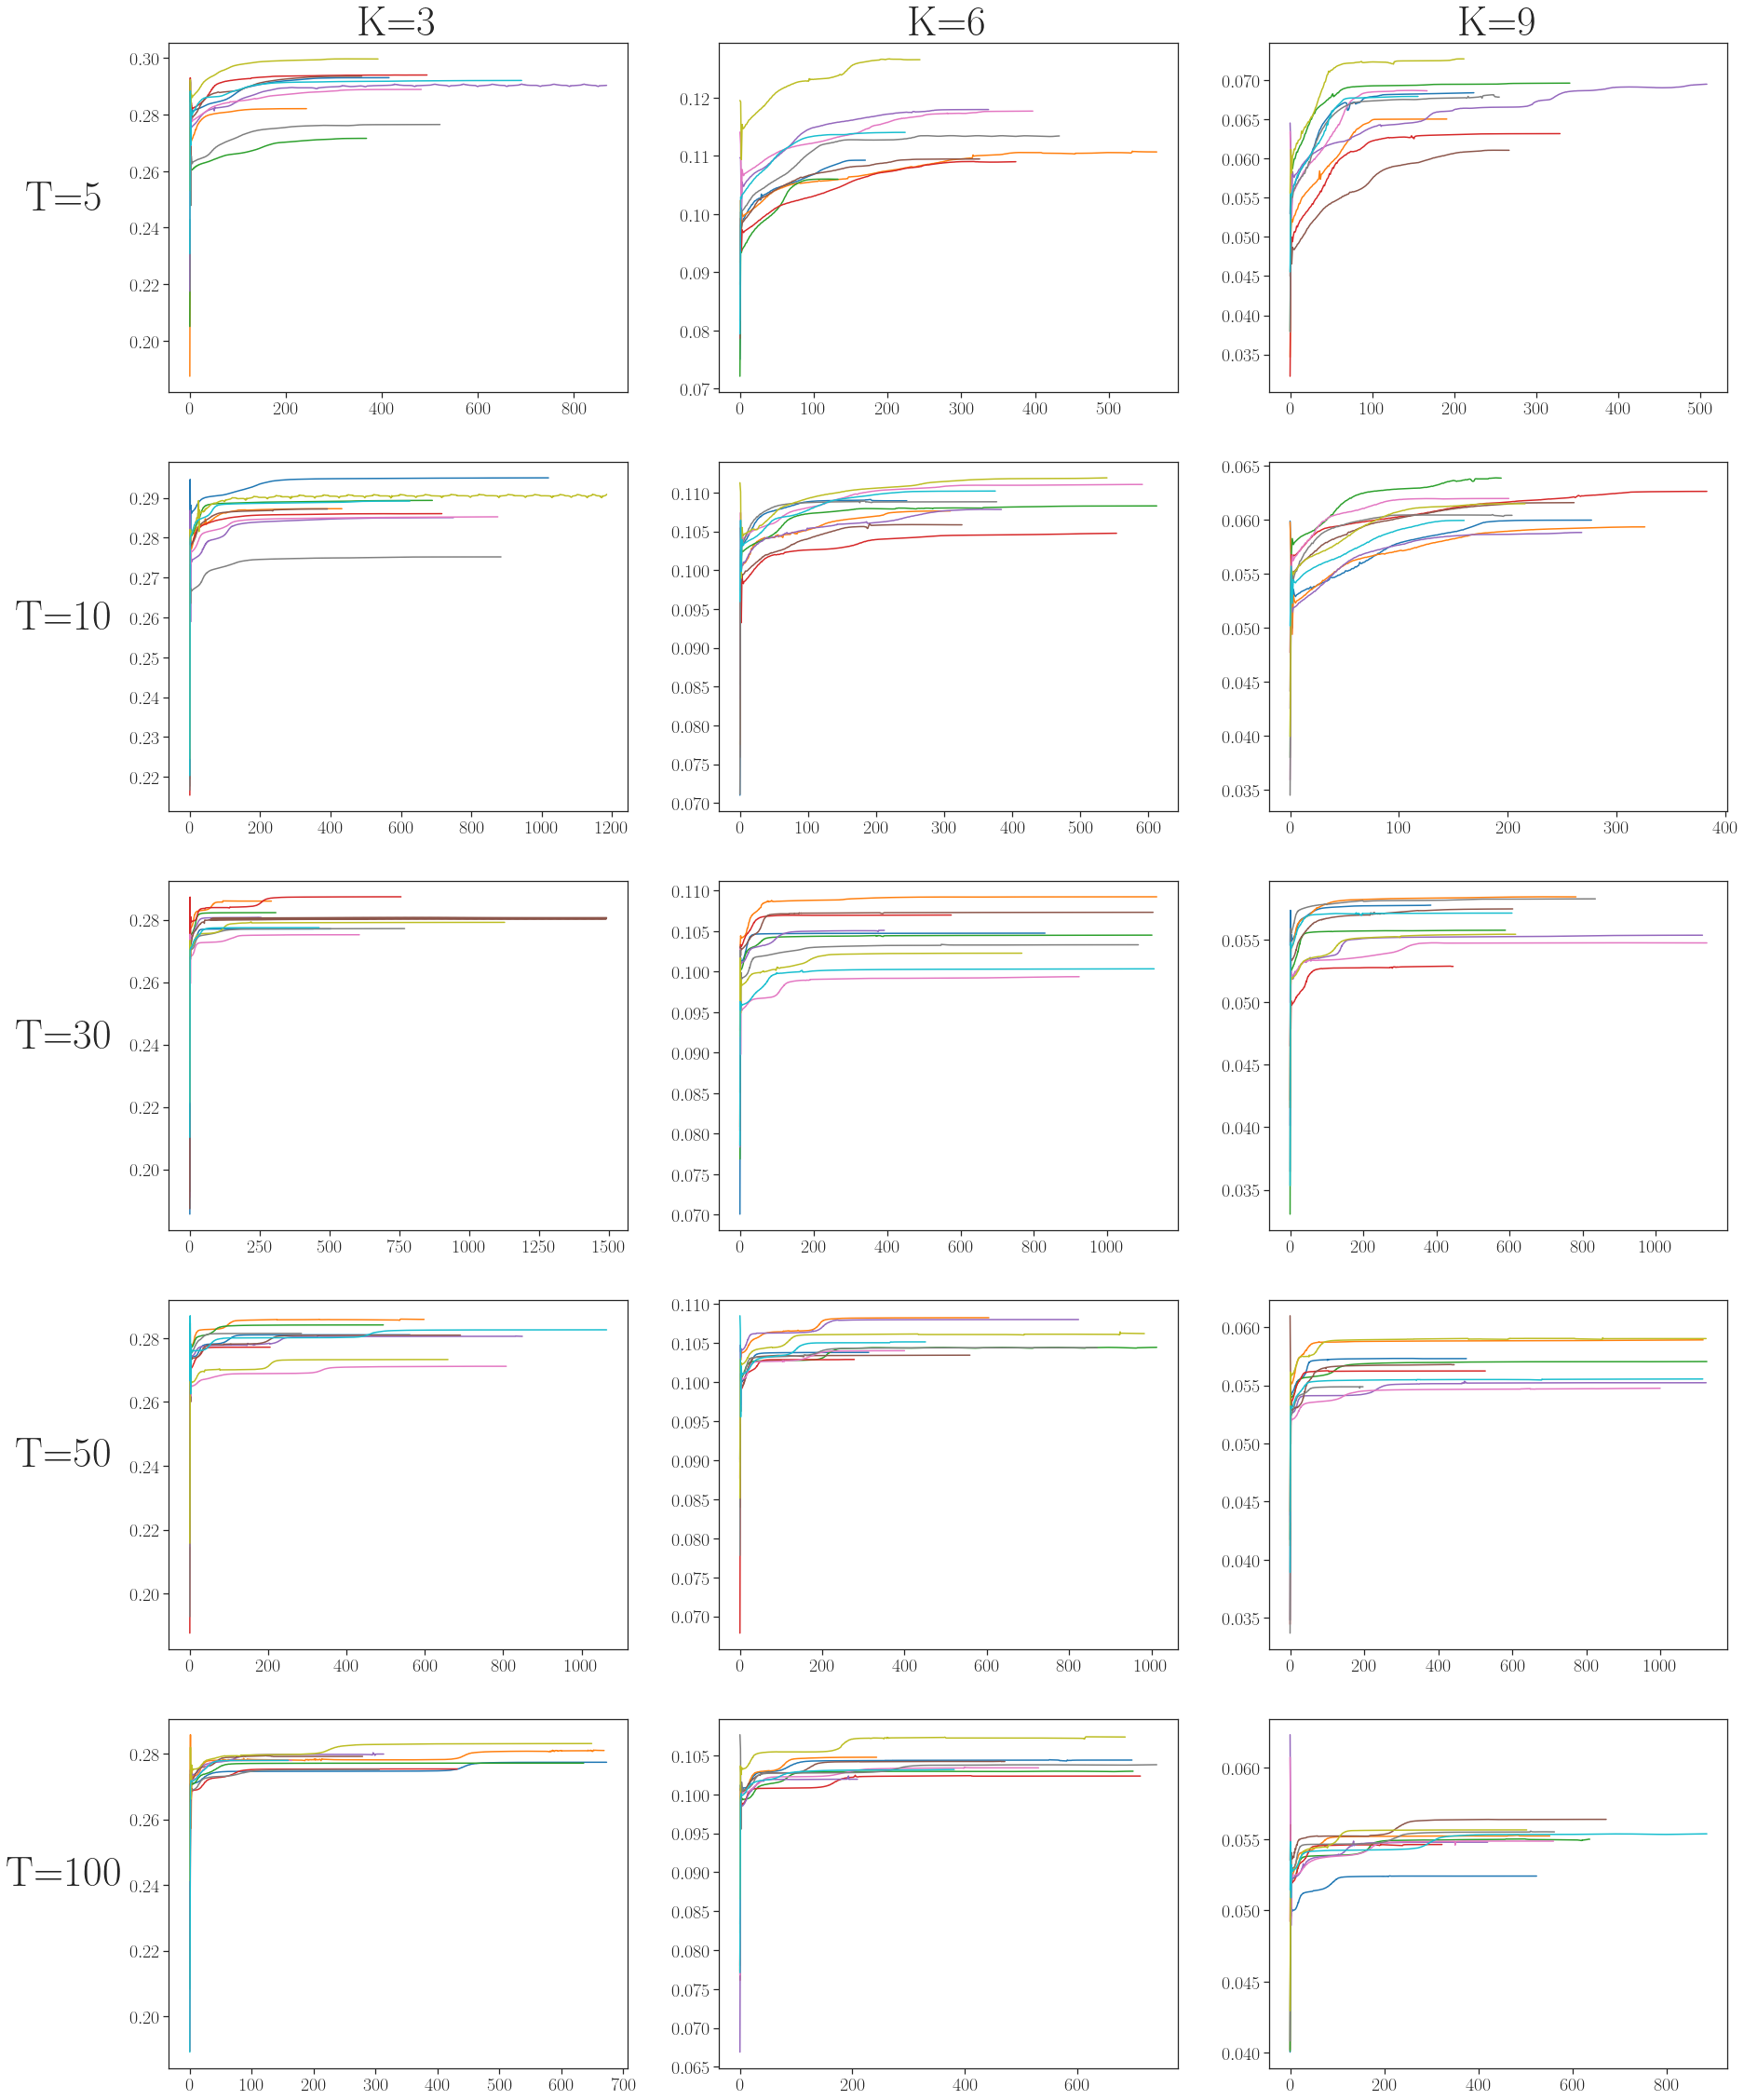

In [128]:
df = pd.DataFrame()
fig, axs = plt.subplots(5,3, figsize=(30, 40))

for i,T in enumerate(Ts): 
    axs[i][0].set_ylabel(f"T={T}", rotation=0, labelpad=70, fontsize=45)
    for j,K in enumerate(K_exps): 
        axs[0,j].set_title(f"K={K}")
        for network_seed in seeds: 
        
            '''
                load ground truth values
            '''
            params = np.load(in_folder + f"params_{network_seed}_{T}_{K}.npz")
            u, mu, Z = params["u"], params["mu"], params["Z"]
            
            '''
                determine best seeds for each run
            '''
            best_score_noexp = -1e10
            seed_noexp = seeds[0]

            best_score_exp = -1e10
            seed_exp = seeds[0]
            # training_3553386411_100_3_NoExp_534591752_None
            
            for inference_seed in seeds: 
                training_noexp = f"training_{network_seed}_{T}_{K}_NoExp_{inference_seed}_None.npz"  
                score_noexp = np.load(out_folder + training_noexp)["losses"][-1]
                if score_noexp > best_score_noexp: 
                    best_score_noexp = score_noexp
                    seed_noexp = inference_seed

                training_exp = f"training_{network_seed}_{T}_{K}_Exp_{inference_seed}_None.npz"
                losses = np.load(out_folder + training_exp)["losses"]
                
                if np.isnan(losses).sum() > 10:
                    continue
                
                score_exp = losses[-1]
                if (score_exp > best_score_exp): #and (score_exp < best_score_exp + 0.02): 
                    best_score_exp = score_exp
                    seed_exp = inference_seed        
            '''
                evaluate and store NoExp results
            '''            

            file_noexp = f"params_{network_seed}_{T}_{K}_NoExp_{seed_noexp}_None.npz"  
            params_noexp = np.load(out_folder + file_noexp)
            u_noexp, v_noexp, w_noexp = params_noexp["u"], params_noexp["v"], params_noexp["w"]
            acc_u, acc_v, _, _ = evaluate_memberships(u, u_noexp, u, v_noexp)
            df = df.append({"seed":network_seed, "T":T, "K":K, "Exp":0, "acc_u":acc_u, "acc_v":acc_v}, ignore_index=True)
            #print(f"NoExp,", f"acc_u={acc_u}, acc_v={acc_v}")     


            '''
                evaluate and store Exp results
            '''
            file_exp = f"params_{network_seed}_{T}_{K}_Exp_{seed_exp}_None.npz"  
            params_exp = np.load(out_folder + file_exp)
            u_exp, v_exp, w_exp, mu_exp, Q = params_exp["u"], params_exp["v"], params_exp["w"], params_exp["mu"], params_exp["Q"]
            acc_mu = evaluate_memberships(mu, mu_exp, mu, mu_exp)[0]
            AUC_Q = calculate_AUC(Z, Q)
            acc_u, acc_v, _, _ = evaluate_memberships(u, u_exp, u, v_exp)
            df = df.append({"seed":network_seed, "T":T, "K":K, "Exp":1, "acc_u":acc_u, "acc_v":acc_v, "acc_mu":acc_mu, "AUC_Q":AUC_Q}, ignore_index=True)
            #print(f"Exp, ", f"acc_mu={acc_mu}, acc_u={acc_u}, acc_v={acc_v}, AUC_Q={AUC_Q}")
            
            '''
                plot losses for Exp Inference
            '''
            training = f"training_{network_seed}_{T}_{K}_Exp_{seed_exp}_None.npz"
            losses = np.load(out_folder + training)["losses"]
            axs[i][j].plot(losses)
plt.show()
       

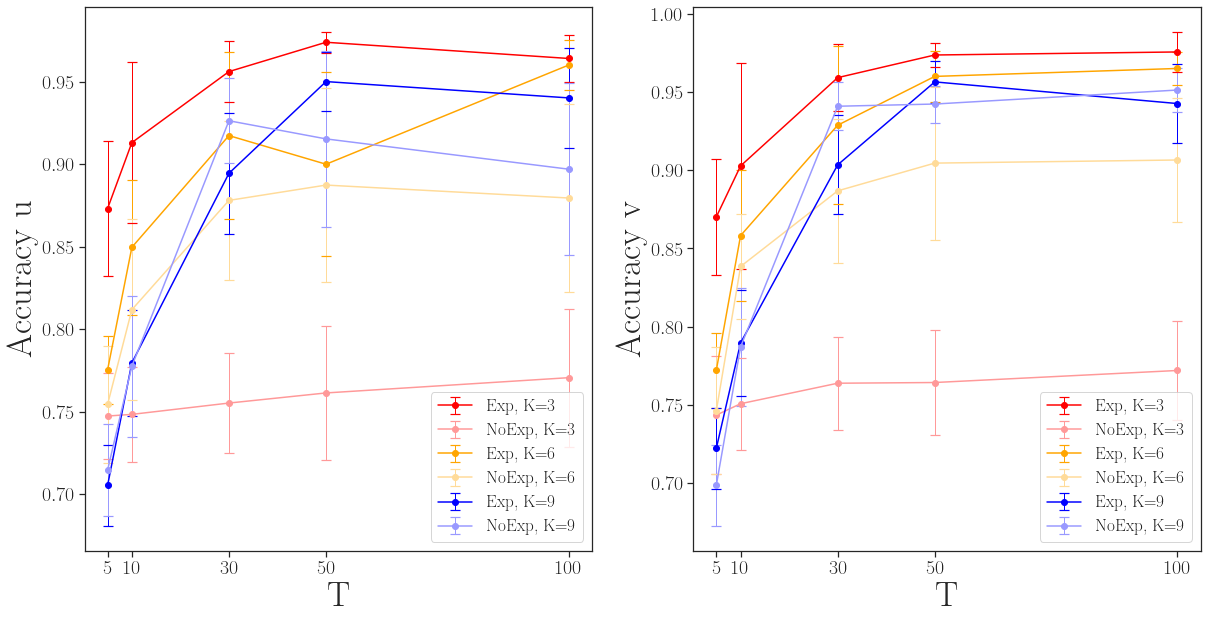

In [129]:
colors = ["red", "orange", "blue"]
fig, axs = plt.subplots(1,2, figsize=(20, 10))

axs[0].set_xticks(Ts)
axs[1].set_xticks(Ts)

axs[0].set_xlabel("T")
axs[1].set_xlabel("T")
#axs[0].set_ylim([0.4,1])

for i,K in enumerate(K_exps): 
    # exposure values
    means_exp_u = []
    errors_exp_u = []
    means_exp_v = []
    errors_exp_v = []

    # no exposure values
    means_noexp_u = []
    errors_noexp_u = []
    means_noexp_v = []
    errors_noexp_v = []

    for T in Ts: 
        exp_acc_u = df.loc[(df['T'] == T) & (df['Exp'] == 1) & (df['K'] == K)]["acc_u"]
        exp_mean_u, exp_error_u = mean_confidence_interval(exp_acc_u)
        means_exp_u.append(exp_mean_u)
        errors_exp_u.append(exp_error_u)

        exp_acc_v = df.loc[(df['T'] == T) & (df['Exp'] == 1) & (df['K'] == K)]["acc_v"]
        exp_mean_v, exp_error_v = mean_confidence_interval(exp_acc_v)
        means_exp_v.append(exp_mean_v)
        errors_exp_v.append(exp_error_v)
        #'''
        noexp_acc_u = df.loc[(df['T'] == T) & (df['Exp'] == 0) & (df['K'] == K)]["acc_u"]
        noexp_mean_u, noexp_error_u = mean_confidence_interval(noexp_acc_u)
        means_noexp_u.append(noexp_mean_u)
        errors_noexp_u.append(noexp_error_u)

        noexp_acc_v = df.loc[(df['T'] == T) & (df['Exp'] == 0) & (df['K'] == K)]["acc_v"]
        noexp_mean_v, noexp_error_v = mean_confidence_interval(noexp_acc_v)
        means_noexp_v.append(noexp_mean_v)
        errors_noexp_v.append(noexp_error_v)
        #'''

    axs[0].errorbar(Ts, np.array(means_exp_u), yerr=errors_exp_u, label=f"Exp, K={K}", color=colors[i], marker='o', capsize=5, capthick=1.2, elinewidth=1)
    axs[0].errorbar(Ts, np.array(means_noexp_u), yerr=errors_noexp_u, label=f"NoExp, K={K}", color=lighten_color(colors[i], amount=0.4), marker='o', capsize=5, capthick=1.2, elinewidth=1)


    axs[1].errorbar(Ts, np.array(means_exp_v), yerr=errors_exp_v, label=f"Exp, K={K}", color=colors[i], marker='o', capsize=5, capthick=1.2, elinewidth=1)
    axs[1].errorbar(Ts, np.array(means_noexp_v), yerr=errors_noexp_v, label=f"NoExp, K={K}", color=lighten_color(colors[i], amount=0.4), marker='o', capsize=5, capthick=1.2, elinewidth=1)


axs[0].legend(fontsize="xx-large")
axs[1].legend(fontsize="xx-large")

axs[0].set_ylabel("Accuracy u")
axs[1].set_ylabel("Accuracy v")
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

#extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#plt.savefig(figure_folder + "accuracy_u.png", bbox_inches=extent.expanded(1.3, 1.21), dpi=300)



#plt.savefig(figure_folder + "memberships.png", dpi=300, bbox_inches='tight')
plt.show()

In [112]:
df.loc[(df['Exp'] == 1) & (df['K'] == 9)]["acc_v"]

41     0.775446
43     0.019696
45     0.724581
47     0.746818
49     0.719299
51     0.693941
53     0.746997
55     0.695395
57     0.646864
59     0.733066
101    0.829458
103    0.760654
105    0.805512
107    0.834666
109    0.806994
111    0.763281
113    0.846535
115    0.769049
117    0.795307
119    0.684668
161    0.871266
163    0.873244
165    0.955501
167   -0.199232
169    0.927507
171    0.923091
173    0.885117
175    0.819199
177    0.943650
179    0.953036
221    0.959778
223    0.960735
225    0.929279
227   -0.077385
229    0.973397
231    0.966527
233    0.960337
235    0.960013
237    0.916093
239   -0.009711
281    0.965216
283    0.938269
285    0.954013
287    0.941605
289    0.347995
291    0.052340
293    0.973669
295    0.954155
297    0.970401
299    0.881319
Name: acc_v, dtype: float64

In [113]:
df.loc[(df['T'] == 50) & (df['Exp'] == 1) & (df['K'] == 9)]["acc_v"]

221    0.959778
223    0.960735
225    0.929279
227   -0.077385
229    0.973397
231    0.966527
233    0.960337
235    0.960013
237    0.916093
239   -0.009711
Name: acc_v, dtype: float64

## Results predicting $\mu$ and $Q$

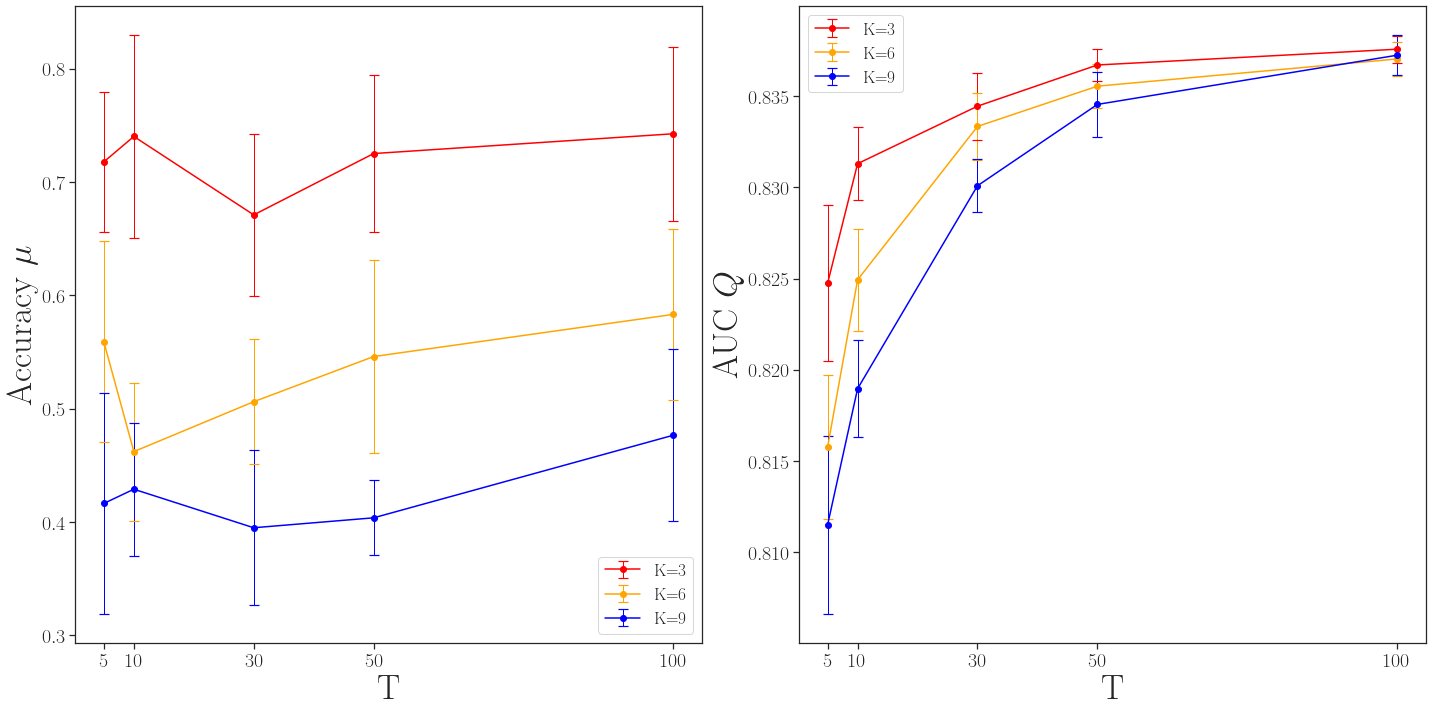

In [130]:
colors = ["red", "orange", "blue"]
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].set_xlabel("T")
axs[1].set_xlabel("T")
axs[0].set_ylabel("Accuracy $\\mu$")
axs[1].set_ylabel("AUC $Q$")

axs[0].set_xticks(Ts)
axs[1].set_xticks(Ts)

for i,K in enumerate(K_exps): 
    # exposure values
    means_exp_mu = []
    errors_exp_mu = []
    means_exp_Q = []
    errors_exp_Q = []

    for T in Ts: 
        exp_acc_mu = df.loc[(df['T'] == T) & (df['Exp'] == 1) & (df['K'] == K)]["acc_mu"]
        exp_mean_mu, exp_error_mu = mean_confidence_interval(exp_acc_mu)
        means_exp_mu.append(exp_mean_mu)
        errors_exp_mu.append(exp_error_mu)

        exp_aucs = df.loc[(df['T'] == T) & (df['Exp'] == 1) & (df['K'] == K)]["AUC_Q"]
        exp_mean_auc, exp_error_auc = mean_confidence_interval(exp_aucs)
        means_exp_Q.append(exp_mean_auc)
        errors_exp_Q.append(exp_error_auc)
        

    axs[0].errorbar(Ts, np.array(means_exp_mu), yerr=errors_exp_mu, label=f"K={K}", color=colors[i], marker='o', capsize=5, capthick=1.2, elinewidth=1)
    axs[1].errorbar(Ts, np.array(means_exp_Q), yerr=errors_exp_Q, label=f"K={K}", color=colors[i], marker='o', capsize=5, capthick=1.2, elinewidth=1)


axs[0].legend(fontsize="xx-large")
axs[1].legend(fontsize="xx-large")

plt.tight_layout()
plt.show()

In [115]:
df.loc[(df['T'] == 50) & (df['Exp'] == 1) & (df['K'] == 9)][["AUC_Q", "acc_u"]]

,AUC_Q,acc_u
221,0.836021,0.977631
223,0.836854,0.940948
225,0.836216,0.921690
227,0.337755,0.165825
229,0.833930,0.938991
231,0.836939,0.981642
233,0.830528,0.925667
235,0.834249,0.962102
237,0.836971,0.913934
239,0.191037,-0.011477


In [116]:
df = pd.DataFrame()

T=50
K=9


for network_seed in seeds: 
    '''
        load ground truth values
    '''
    params = np.load(in_folder + f"params_{network_seed}_{T}_{K}.npz")
    u, mu, Z = params["u"], params["mu"], params["Z"]

    '''
        determine best seeds for each run
    '''
    best_score_noexp = -1e10
    seed_noexp = seeds[0]

    best_score_exp = -1e10
    seed_exp = seeds[0]

    for inference_seed in seeds: 


        '''
            evaluate and store Exp results
        '''
        file_exp = f"params_{network_seed}_{T}_{K}_Exp_{inference_seed}_None.npz"  
        params_exp = np.load(out_folder + file_exp)
        u_exp, v_exp, w_exp, mu_exp, Q = params_exp["u"], params_exp["v"], params_exp["w"], params_exp["mu"], params_exp["Q"]
        acc_mu = evaluate_memberships(mu, mu_exp, mu, mu_exp)[0]
        AUC_Q = calculate_AUC(Z, Q)
        acc_u, acc_v, _, _ = evaluate_memberships(u, u_exp, u, v_exp)
        df = df.append({"seed":network_seed, "T":T, "K":K, "Exp":1, "acc_u":acc_u, "acc_v":acc_v, "acc_mu":acc_mu, "AUC_Q":AUC_Q}, ignore_index=True)


        '''
            plot losses for Exp Inference
        '''
        training = f"training_{network_seed}_{T}_{K}_Exp_{inference_seed}_None.npz"
        losses = np.load(out_folder + training)["losses"]
        
                
        print_bold(f"{network_seed}, {inference_seed}: final loss={losses[-1]}, acc_u={acc_u}, acc_v={acc_v}, AUC_Q={AUC_Q}")
    print("\n")

697752728, 697752728: final loss=0.05723873790840569, acc_u=0.9475424245572742, acc_v=0.9526864523849343, AUC_Q=0.8360189491093497
697752728, 4190089612: final loss=0.057213165361452614, acc_u=0.9686461096131579, acc_v=0.9630054890753353, AUC_Q=0.8361758490648346
697752728, 1176914559: final loss=0.0572361310141232, acc_u=0.9793374954471804, acc_v=0.9572282558734148, AUC_Q=0.8361613608188827
697752728, 3077924848: final loss=0.0572522002537878, acc_u=0.8884684000533051, acc_v=0.9534066460387629, AUC_Q=0.836053086547714
697752728, 315917623: final loss=0.05723634048777904, acc_u=0.8707292549442406, acc_v=0.8862125645778427, AUC_Q=0.83608913096288
697752728, 2544020234: final loss=0.05730904284581292, acc_u=0.9776306790182029, acc_v=0.9597778943740343, AUC_Q=0.83602065509162
697752728, 1077758578: final loss=0.05722742117785095, acc_u=0.9085756751221068, acc_v=0.9215259711095166, AUC_Q=0.8363358390641112
697752728, 4071300106: final loss=0.05726142966553713, acc_u=0.9008749082545837, acc

/home/jschulz/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: divide by zero encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


3077924848, 315917623: final loss=0.05622218573478176, acc_u=0.871189768771724, acc_v=0.8872802615966908, AUC_Q=0.8327318599394685
3077924848, 2544020234: final loss=0.05624573324161371, acc_u=0.9713224669948123, acc_v=0.9644933676683283, AUC_Q=0.8327753653533658
3077924848, 1077758578: final loss=0.05623372604480861, acc_u=0.9189193969840737, acc_v=0.9238773621542044, AUC_Q=0.8328465444848914
3077924848, 4071300106: final loss=0.056218775881478535, acc_u=0.9128363270278639, acc_v=0.8830593551183218, AUC_Q=0.8327395485667218
3077924848, 534591752: final loss=0.05621734044393728, acc_u=0.9575221179394318, acc_v=0.9749320209325606, AUC_Q=0.8327304690773126
3077924848, 3553386411: final loss=0.056220757195261, acc_u=0.9489298584180769, acc_v=0.9738688234904358, AUC_Q=0.8328285977902896


315917623, 697752728: final loss=0.05521688548049715, acc_u=0.9510448472433046, acc_v=0.9566335428757311, AUC_Q=0.8339828059073715
315917623, 4190089612: final loss=0.05518079377372602, acc_u=0.9640567169

## Analyzing strange Results for one particular seed combination
### 3553386411, 315917623: final loss=0.1052733126064506, acc_u=-0.011476652840953498, acc_v=-0.009711150599327518, AUC_Q=0.19103727525930866

In [117]:
np.set_printoptions(suppress=True)

In [118]:
net_seed, inf_seed = 3553386411, 315917623
file_exp = f"params_{net_seed}_{T}_{K}_Exp_{inf_seed}_None.npz"  
params_exp = np.load(out_folder + file_exp)
u_exp, v_exp, w_exp, mu_exp, Q = params_exp["u"], params_exp["v"], params_exp["w"], params_exp["mu"], params_exp["Q"]
acc_mu = evaluate_memberships(mu, mu_exp, mu, mu_exp)[0]
AUC_Q = calculate_AUC(Z, Q)
acc_u, acc_v, _, _ = evaluate_memberships(u, u_exp, u, v_exp)

In [119]:
np.round(u_exp,1)

array([[ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00

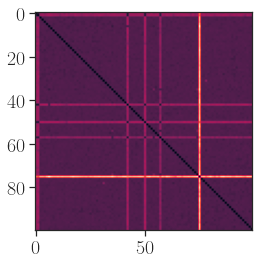

In [120]:
plt.imshow(Q.sum(axis=0))

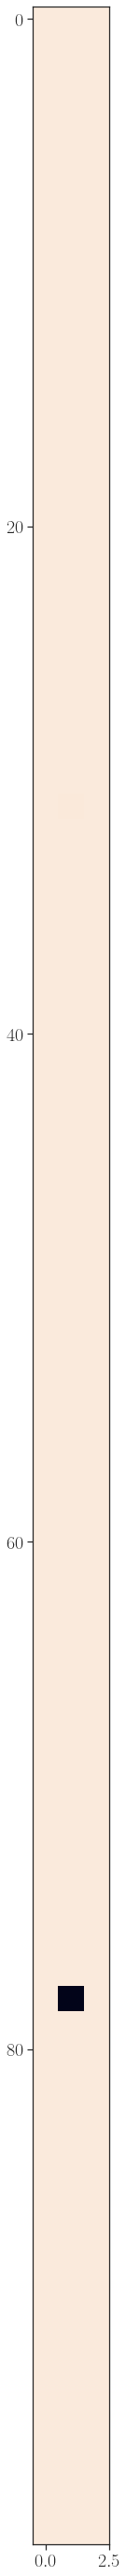

In [121]:
fig, ax = plt.subplots(1,1, figsize=(10,50))
plt.imshow(u_exp)